In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.feature_selection import chi2
from scipy.stats import median_test, ttest_ind
import seaborn as sns
from scipy.stats import mannwhitneyu

In [2]:
df = pd.read_csv('app_data.csv',parse_dates=True)
df = df.set_index('Unnamed: 0')

In [3]:
def preprocess(df):
    df.created_at  = pd.to_datetime(df.created_at)
    df = df.sort_values(['uuid','created_at'])
    df['delta_ts'] = df.created_at.diff()
    df['last_uuid'] = df.uuid.shift()
    df['is_new_session'] = (df['delta_ts'] > pd.Timedelta("60m")) | (df['last_uuid'] != df['uuid'])
    df['session_id'] = df.is_new_session.cumsum()
    return df
df = preprocess(df)

In [4]:
# two sample sessions
df[(df.session_id >= 2) & (df.session_id <= 9)].reset_index()[['uuid','created_at','activity_id','session_id']]

,uuid,created_at,activity_id,session_id
0,2990,2016-12-28 09:40:57.271,604,2
1,2990,2016-12-28 09:41:14.758,608,2
2,2990,2016-12-28 09:41:28.846,603,2
3,2990,2016-12-28 09:41:44.542,606,2
4,2990,2016-12-28 09:42:01.644,602,2
...,...,...,...,...
455,2990,2017-01-04 21:57:28.707,605,9
456,2990,2017-01-04 21:57:56.277,608,9
457,2990,2017-01-04 21:58:08.930,603,9
458,2990,2017-01-04 21:58:19.636,606,9


In [5]:
def session_length(df):
    return df.groupby('session_id')['created_at'].agg(max) - df.groupby('session_id')['created_at'].agg(min)

In [6]:
session_len = session_length(df).astype('timedelta64[s]')/60

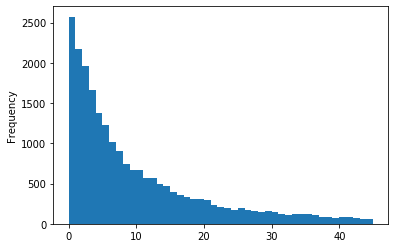

In [7]:
session_len[session_len < 45].plot.hist(bins=45)

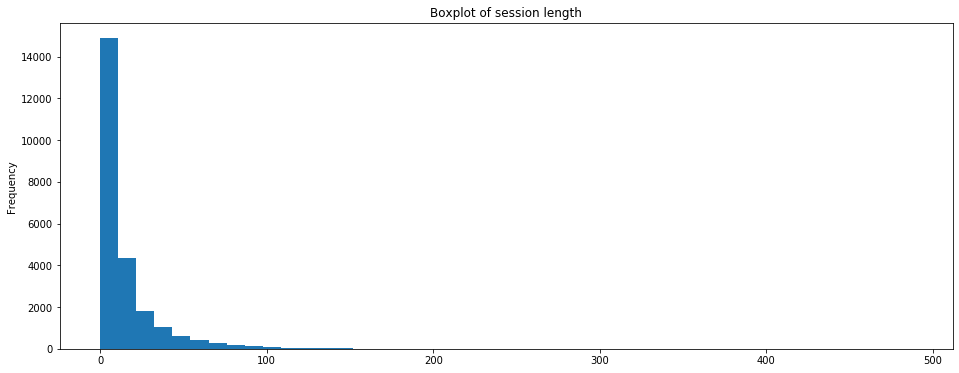

In [8]:
# histogramm of session length in minutes
plt.figure(figsize=(16, 6))
plt.title('Boxplot of session length')
session_len.rename('session length in minutes').plot.hist(bins=45)

plt.savefig('hist_session_length.png')

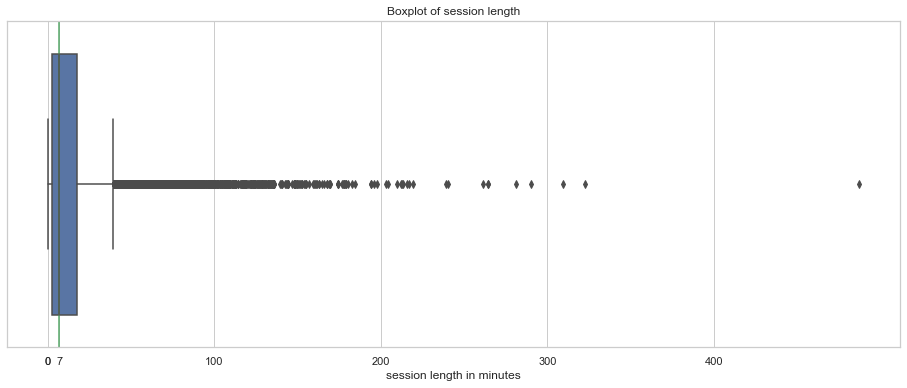

In [9]:
sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))
plt.title('Boxplot of session length')
plt.axvline(session_len.median(), 0,1,c='g')
ax = sns.boxplot(x=session_len.rename('session length in minutes'))
plt.xticks([0,session_len.median()]+list(range(0,500,100)))
plt.savefig('boxplot_session_length.png')

In [10]:
#Amount of sessions per day for each customer, that has at more than one session on one day
#Start several sessions on one day, as opposed to starting a session on one day, ending it in the next and then starting a session that day
def recurring_session(df):
    '''Given a dataframe df with columns 'session_id','uuid' and 'created_at' returns a tupel (recurring, no_same_day_sessions)
    where
        recurring - pd.Series with index=uuid and boolean values, wheather the uuid is a recurring customer.
        no_same_day_sessions - pd.Series with multi-index (uuid,created_at) with values the number of sessions the user has on this specific day, greater than 0
    
    '''
    no_same_day_sessions = df.groupby(['session_id','uuid'])['created_at'].agg('min').dt.date.reset_index().groupby(['uuid','created_at']).size()
    recurring = no_same_day_sessions.groupby('uuid').max() > 1
    return recurring, no_same_day_sessions
rec, no_same = recurring_session(df)

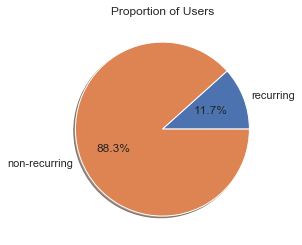

In [11]:
# recurring - percentage of users who do more than one session on at least one day.
labels = 'recurring', 'non-recurring'
plt.pie([sum(rec) / rec.size, 1- sum(rec) / rec.size],labels=labels, autopct='%1.1f%%',
        shadow=True)
plt.title('Proportion of Users')
plt.savefig('pie.png')

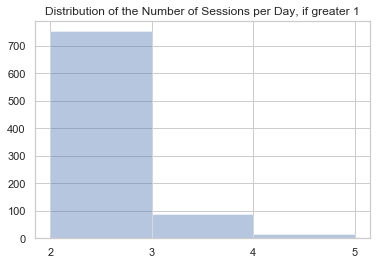

In [12]:
n = no_same.groupby('uuid').max()[no_same.groupby('uuid').max()>1].values
plt.title('Distribution of the Number of Sessions per Day, if greater 1')
sns.distplot(n,bins=np.arange(2,6,1),kde=False)
plt.xticks(np.arange(2,6,1))
plt.savefig('how_many_sessions.png')

plt.show()

In [13]:
groups = pd.read_csv('test_groups.csv',parse_dates=True)
group_alias = {'control':0,'test':1}
groups['test_group'] = groups['test_group'].replace(group_alias)

dfl = pd.read_csv('learner_item_data.csv',parse_dates=True)
dfl = preprocess(dfl)
dfl = dfl.set_index('uuid').join(groups.set_index('uuid'), how='inner').reset_index()

# control group A
group_A = dfl[dfl['test_group']==0]
#test group B
group_B = dfl[dfl['test_group']==1]

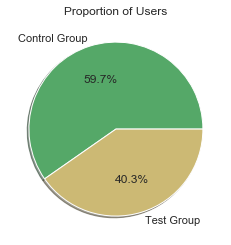

In [14]:
labels = 'Control Group', 'Test Group'
plt.pie([group_A.size, group_B.size ],labels=labels, autopct='%1.1f%%', shadow=True,colors=['g','y'])
plt.title('Proportion of Users')
        
plt.savefig('pieAB.png')

In [15]:
#Perform a Mood's median test.
#
#Test that two or more samples come from populations with the same median.
_, p_value, median, _ = median_test(session_length(group_A),session_length(group_B))
p_value, median.astype('timedelta64[s]')

(0.45640220695523825, numpy.timedelta64(418,'s'))

$p = 0.456$ is the chance that we observe those samples under the assumption that there is no difference between the medians of group $A$ and $B$.
There is no statistical significance increase in median length of sessions.

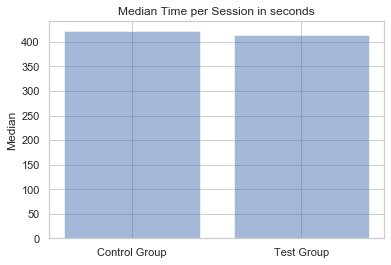

In [16]:
objects = ('Control Group', 'Test Group')
y_pos = np.arange(len(objects))
performance = [session_length(group_A).astype('timedelta64[s]').median(),session_length(group_B).astype('timedelta64[s]').median()]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Median')
plt.title('Median Time per Session in seconds')

plt.savefig('median_timeAB.png')
plt.show()

In [17]:
# proportion of users doing more than one session on at least one day

In [18]:
# proportion of users doing more than one session on at least one day, in the control and the test group respectively
rec_A, no_same_A = recurring_session(group_A)
rec_B, no_same_B = recurring_session(group_B)
proportion_A = sum(rec_A) / rec_A.size
proportion_B =sum(rec_B) / rec_B.size
proportion_A, proportion_B

(0.11394755163611046, 0.12015758371634931)

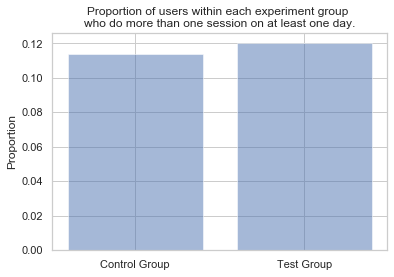

In [19]:
objects = ('Control Group', 'Test Group')
y_pos = np.arange(len(objects))
performance = [proportion_A,proportion_B]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Proportion')
plt.title('Proportion of users within each experiment group \nwho do more than one session on at least one day.')

plt.savefig('proportionAB.png')
plt.show()

In [20]:
rec, _ =recurring_session((dfl))

In [21]:
# chi-squared test, to determine wheater the attribute 'recurring' of a user is dependent on the feature 'test_group' 
chi2(dfl.groupby('uuid')[['test_group']].max(), rec)

(array([0.39166074]), array([0.53142773]))

In [22]:
# The value of the Mann-Whithey U test should be 1/2 of the p-value of the chi-2 test, because the chi-2 test is two-tailed
stat, p_value = mannwhitneyu(rec_A, rec_B,use_continuity=True, alternative="less")
print(f"Mann-Whitney U test for null hypothesis B <= A is {p_value:0.3f}")

Mann-Whitney U test for null hypothesis B <= A is 0.207


In [23]:
ttest_ind(rec_B.astype('int'), rec_A.astype('int'), equal_var=False)

Ttest_indResult(statistic=0.8143269096010468, pvalue=0.4154877045722939)